# In this notebook we reproduce Figure 2 of the paper.

In [1]:
import sys
import os
import json
import time
import logging
import networkx as nx

# Now we can import modules from python_fbas
from python_fbas.fbas_graph import FBASGraph
from python_fbas.fbas_graph_analysis import is_fba_resilient_approx, find_disjoint_quorums
from python_fbas.constellation.constellation import *
import python_fbas.constellation.config as config

# %load_ext line_profiler

# Create a logger
logger = logging.getLogger("JupyterLogger")

# Remove all handlers (not just `clear()`, since `hasHandlers()` checks parent loggers too)
while logger.hasHandlers():
    logger.removeHandler(logger.handlers[0])

debug_level = logging.INFO

# Add a StreamHandler to send logs to the notebook output
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(debug_level)  # Ensure the handler captures DEBUG logs
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

logger.addHandler(handler)
logger.setLevel(debug_level)

logger.info("Logger is set up and ready to use.")

2025-02-13 17:50:04,990 - INFO - Logger is set up and ready to use.


For each number of organization, we generate 50 random single-universe regular FBA systems and we then compute 3 overlays: constellation, a random Erdos-Renyi graph that is FBA-resilient and has diameter 2, and an overlay obtained using the greedy strategy. We then plot statistics including average degree, median degree, and max degree.

Note that the results may depend on your hardware because, to avoid taking too long, we timeout after 30 seconds when computing a constellation overlay and then retry with in a more constrained search space (which may now only include a less optimal solution).

In [2]:
DATA_CACHE_DIR="data/tmp"
if not os.path.exists(DATA_CACHE_DIR):
    os.makedirs(DATA_CACHE_DIR)
# uncomment to clear cache:
# os.system(f"rm -rf {DATA_CACHE_DIR}/*")

In [ ]:
logger.info("Computing overlays; this can take a long time")

config.timeout = 30 # timeout to compute the constellation clusters in seconds
NUM_SAMPLES=50
N_THRESHOLDS=5
# NUM_ORGS_SEQUENCE=[7, 16, 25, 50, 75, 100, 125, 150, 175, 200]
NUM_ORGS_SEQUENCE=[7, 16, 25, 50, 75, 100]
constellation_overlays:dict[int,list[nx.Graph]] = {n : list() for n in NUM_ORGS_SEQUENCE}
erdos_renyi:dict[int,list[nx.Graph]] = {n : list() for n in NUM_ORGS_SEQUENCE}
greedy:dict[int,list[nx.Graph]] = {n : list() for n in NUM_ORGS_SEQUENCE}
for NUM_ORGS in NUM_ORGS_SEQUENCE:
    logger.debug(f"Computing/loading overlays for {NUM_ORGS} organizations")
    dir = f"{DATA_CACHE_DIR}/{NUM_ORGS}"
    os.makedirs(dir, exist_ok=True)

    # First, we create NUM_SAMPLES random single-universe FBA systems with NUM_ORGS each.
    fbases:list[dict] = []
    for i in range(NUM_SAMPLES):
        f = f'{dir}/fbas_{i}.json'
        if os.path.exists(f):
            with open(f, 'r') as f:
                fbases.append(json.load(f))
            continue
        else:
            # random thresholds between 1/2 and 5/6 of the number of validators with N_THRESHOLDS different thresholds:
            fbas = random_single_universe_regular_fbas(NUM_ORGS, int(NUM_ORGS/2)+1, int(5*NUM_ORGS/6)+1, N_THRESHOLDS)
            # recompute while there are disjoint quorums:
            while find_disjoint_quorums(single_universe_regular_fbas_to_fbas_graph(fbas)):
                fbas = random_single_universe_regular_fbas(NUM_ORGS, int(NUM_ORGS/2)+1, int(5*NUM_ORGS/6)+1, N_THRESHOLDS)
            fbases.append(fbas)
            with open(f, 'w') as f:
                json.dump(fbas, f)

    # For each FBAS, compute the constellation overlay:
    config.max_num_clusters = 4 if NUM_ORGS <= 100 else 3
    config.min_cluster_size = int((NUM_ORGS//config.max_num_clusters)*0.60)
    for i, fbas in enumerate(fbases):
        f = f'{dir}/overlay_{i}.json'
        if os.path.exists(f):
            with open(f, 'r') as f:
                constellation_overlays[NUM_ORGS].append(nx.node_link_graph(json.load(f)))
            continue
        else:
            # compute the constellation overlay and measure how long it takes:
            start_time = time.time()
            # try again while we get a timeout
            overlay = None
            while overlay is None:
                try:
                    overlay = constellation_overlay(fbas)
                except subprocess.TimeoutExpired:
                    new_size = max(int(config.min_cluster_size * 1.1), config.min_cluster_size+1) # increase by 10% or 1, whichever is larger
                    if new_size < NUM_ORGS/config.max_num_clusters:
                        config.min_cluster_size = new_size
                        logger.info(f"min_cluster_size increased to {config.min_cluster_size} out of {NUM_ORGS}")
            end_time = time.time()
            logger.debug(f"Computing constellation overlay for {NUM_ORGS} organizations took {end_time - start_time} seconds")
            constellation_overlays[NUM_ORGS].append(overlay)
            # We save the overlay to a file for examination
            with open(f, 'w') as f:
                json.dump(nx.node_link_data(overlay), f)

    # Now the Erdos-Renyi graphs:
    # We generate a random Erdos-Renyi graph with edge probability k/N for k from 1 to N until we find a graph that has diameter 2 and that is FBA-resilient.
    for i, fbas in enumerate(fbases):
        fbas_graph:FBASGraph = single_universe_regular_fbas_to_fbas_graph(fbas)
        vertices = fbas_graph.vertices()
        validators = fbas_graph.validators
        overlay = {}
        f = f'{dir}/erdos_renyi_{i}.json'
        if os.path.exists(f):
            with open(f, 'r') as f:
                overlay = nx.node_link_graph(json.load(f))
            erdos_renyi[NUM_ORGS].append(overlay)
        else:
            start_time = time.time()
            for d in range(10, len(validators)):
                overlay = nx.erdos_renyi_graph(len(validators), d/len(validators))
                # relabel with the validator names:
                overlay = nx.relabel_nodes(overlay, {i: v for i, v in enumerate(validators)})
                if is_fba_resilient_approx(fbas_graph, overlay) and nx.diameter(overlay) == 2:
                    break
            with open(f, 'w') as f:
                json.dump(nx.node_link_data(overlay), f)
            end_time = time.time()
            logger.debug(f"Found Erdos-Renyi graph with diameter 2 and that is FBA-resilient for {NUM_ORGS} organizations in {end_time - start_time} seconds")
            erdos_renyi[NUM_ORGS].append(overlay)

    # Finally, the greedy graphs:
    for i, fbas in enumerate(fbases):
        f = f'{dir}/greedy_{i}.json'
        if os.path.exists(f):
            with open(f, 'r') as f:
                overlay = nx.node_link_graph(json.load(f))
            greedy[NUM_ORGS].append(overlay)
            continue
        else:
            logger.debug(f"Computing greedy graph for {NUM_ORGS} organizations")
            start_time = time.time()
            overlay = greedy_overlay(fbas)
            # check it's resilient:
            assert is_fba_resilient_approx(single_universe_regular_fbas_to_fbas_graph(fbas), overlay)
            end_time = time.time()
            with open(f, 'w') as f:
                json.dump(nx.node_link_data(overlay), f)
            logger.debug(f"Found greedy graph for {NUM_ORGS} organizations in {end_time - start_time} seconds")
            greedy[NUM_ORGS].append(overlay)

logger.info("Finished computing/loading overlays")

2025-02-13 17:50:05,010 - INFO - Computing overlays; this can take a long time
2025-02-13 17:50:18,899 - INFO - Finished computing overlays


Now that we have compute the overlays, we plot some comparison graphs.

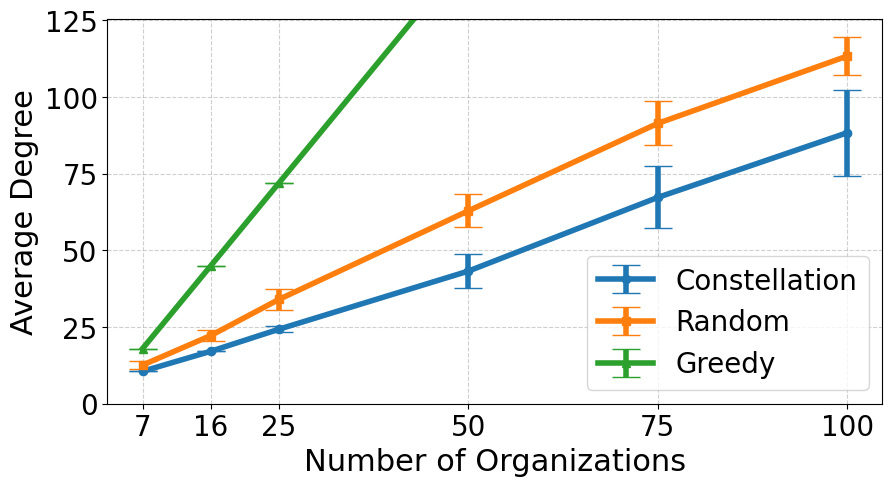

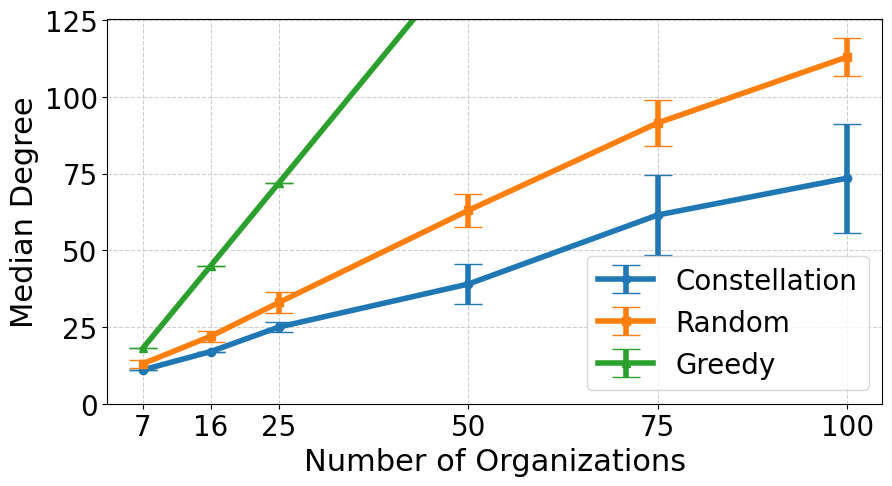

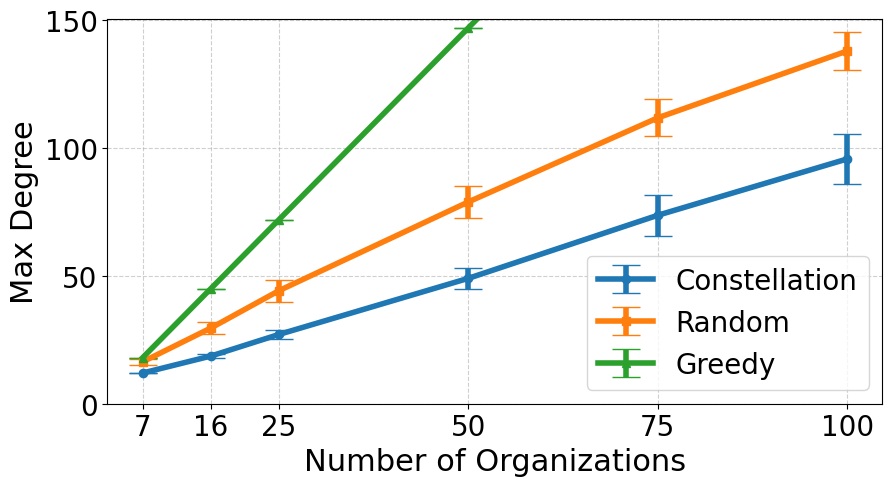

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import statistics

# Functions to compute different degree statistics
def avg_degree(graph):
    return sum([d for _, d in graph.degree()]) / len(graph)

def median_degree(graph):
    return statistics.median([d for _, d in graph.degree()])

def max_degree(graph):
    return max([d for _, d in graph.degree()])

def avg_statistic(overlays, func):
    return sum([func(graph) for graph in overlays]) / len(overlays)

def median_statistic(overlays, func):
    return statistics.median([func(graph) for graph in overlays])

def stddev_statistic(overlays, func):
    return statistics.stdev([func(graph) for graph in overlays])

# NUM_ORGS_SEQUENCE = [7,16,25]
NUM_ORGS_SEQUENCE = [7, 16, 25, 50, 75, 100]

# Compute statistics for each number of organizations
def compute_stats(data):
    return {
        n: [
            avg_statistic(data[n], avg_degree), 
            median_statistic(data[n], median_degree), 
            avg_statistic(data[n], max_degree),
            stddev_statistic(data[n], avg_degree),  # Stddev for mean plot
            stddev_statistic(data[n], median_degree),  # Stddev for median plot
            stddev_statistic(data[n], max_degree)  # Stddev for max plot
        ] for n in NUM_ORGS_SEQUENCE
    }

# Compute data for both models
constellation_data = compute_stats(constellation_overlays)
erdos_renyi_data = compute_stats(erdos_renyi)
greedy_data = compute_stats(greedy)

# Extract data for plotting
num_orgs = np.array(NUM_ORGS_SEQUENCE)

# Plot function
def plot_data(stat_index, ylabel, title):
    # Extract statistics
    constellation_means = [constellation_data[n][stat_index] for n in num_orgs]
    constellation_stddevs = [constellation_data[n][stat_index + 3] for n in num_orgs]
    erdos_renyi_means = [erdos_renyi_data[n][stat_index] for n in num_orgs]
    erdos_renyi_stddevs = [erdos_renyi_data[n][stat_index + 3] for n in num_orgs]
    greedy_means = [greedy_data[n][stat_index] for n in num_orgs]
    greedy_stddevs = [greedy_data[n][stat_index + 3] for n in num_orgs]
    
    # Offset for separation
    offset = 0
    x_constellation = num_orgs - offset
    x_erdos_renyi = num_orgs
    x_greedy = num_orgs + offset

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.errorbar(x_constellation, constellation_means, yerr=constellation_stddevs, fmt='o-', label='Constellation', capsize=10, linewidth=4)
    plt.errorbar(x_erdos_renyi, erdos_renyi_means, yerr=erdos_renyi_stddevs, fmt='s-', label='Random', capsize=10, linewidth=4)
    plt.errorbar(x_greedy, greedy_means, yerr=greedy_stddevs, fmt='^-', label='Greedy', capsize=10, linewidth=4)

    # Adjust y-axis limits to fit first two curves, ensuring all error bars are visible
    # ymin = min(min(constellation_means) - max(constellation_stddevs), min(erdos_renyi_means) - max(erdos_renyi_stddevs))
    ymin = 0
    ymax = max(max(constellation_means) + max(constellation_stddevs), max(erdos_renyi_means) + max(erdos_renyi_stddevs)) + 5
    plt.ylim(ymin, ymax)

    # Labels and legend
    plt.xlabel("Number of Organizations")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(num_orgs)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Show the plot
    plt.show()

plt.rcParams.update({
    'font.size': 16,         # Base font size
    'axes.titlesize': 22,    # Title font size
    'axes.labelsize': 22,    # X and Y label font size
    'xtick.labelsize': 20,   # X-axis tick labels font size
    'ytick.labelsize': 20,   # Y-axis tick labels font size
    'legend.fontsize': 20    # Legend font size
})

# Generate three plots: Mean, Median, Max Degree
plot_data(0, "Average Degree", "")
plot_data(1, "Median Degree", "")
plot_data(2, "Max Degree", "")


In [ ]:
print(constellation_data[100][0]/erdos_renyi_data[100][0])

88.34559999999998
113.33333333333334
